**извлечение признаков из текста на естественном языке**

кластеризатор текстов   
SnowballStemmer + TFIDF + DBSCAN

_Евгений Борисов <esborisov@sevsu.ru>_

## библиотеки

In [1]:
import re
# import gzip
import numpy as np
import numpy.random as rng
import pandas as pd
from tqdm.notebook import tqdm

# from matplotlib import pyplot as plt

np.set_printoptions(precision=2) # вывод на печать чисел до 2 знака
pd.options.display.max_colwidth = 200 

tqdm.pandas()

In [2]:
from sklearn import __version__ as SKLEARN_VERSION
SKLEARN_VERSION

'1.0.2'

## тексты

In [3]:
# загружаем тексты
data = pd.read_pickle('../data/text/news.pkl.gz')
print('записей:',len(data))

записей: 3196


In [4]:
data.sample(2)

,text,tag
3016,"Автомобильные эксперты страны составили ТОП-5 седанов, которые навсегда покинули автомобильный рынок России. Часть из них была снята с продаж в нашей стране по причине низких показателей объемов р...",auto
1825,"Иран и Россия заключили меморандум о сотрудничестве в области нефти, который включает 22 пункта. Документ подписали замглавы Минэнерго РФ Кирилл Молодцов и замминистра нефти Ирана Амир Хосейн Зама...",economics


## токенизация и очистка

In [5]:
# применяет список замен pat к строке s
def replace_patterns(s,pat):
    if len(pat)<1: return s
    return  replace_patterns( re.sub(pat[0][0],pat[0][1],s), pat[1:] )

# нормализация текста
def string_normalizer(s):
    pat = [
       [r'ё','е'] # замена ё для унификации
       ,[r'</?[a-z]+>',' '] # удаляем xml
       ,[r'[^a-zа-я\- ]+',' '] # оставляем только буквы, пробел и -
       ,[r' -\w+',' '] # удаляем '-й','-тый' и т.п.
       ,[r'\w+- ',' ']
       ,[r' +',' '] # удаляем повторы пробелов
    ]
    return replace_patterns(s.lower(),pat).strip()

In [6]:
data['ctext'] = data['text'].progress_apply(string_normalizer)

  0%|          | 0/3196 [00:00<?, ?it/s]

##  Vectorizer

In [7]:
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords as nltk_stopwords

stopwords = set(nltk_stopwords.words('russian'))
stemmer = SnowballStemmer('russian')

# разрезаем стоки на слова, выкидываем stopwords, выполняем стеминг
def tokenizer_stemmer(s,stemmer=stemmer,stopwords=stopwords): 
    for w in s.split(' '):
        if w in stopwords: continue
        o = stemmer.stem(w).replace('^','')
        if len(o)<2: continue
        yield o        

In [94]:
%%time

from sklearn.feature_extraction.text import TfidfVectorizer

X = TfidfVectorizer(
        use_idf=False,
        norm='l2',
        tokenizer=tokenizer_stemmer,
        token_pattern=None,
    ).fit_transform( data['ctext'] )

CPU times: user 56.2 s, sys: 32.5 ms, total: 56.3 s
Wall time: 56.9 s


In [95]:
# %%time

# from sklearn.feature_extraction.text import CountVectorizer

# X = CountVectorizer(
#     tokenizer=tokenizer_stemmer,
#     token_pattern=None,
#   ).fit_transform( data['ctext'] )

In [ ]:
# X.sum(axis=1).max()

In [96]:
X.shape

(3196, 36369)

## кластеризируем

In [103]:
%%time 

from sklearn.cluster import DBSCAN

data['cluster'] = DBSCAN(eps=1.05,min_samples=11).fit(X).labels_
# data['cluster'] = DBSCAN(eps=11.5,min_samples=2).fit(X).labels_ # CountVectorizer
data['cluster'].drop_duplicates().count()

CPU times: user 803 ms, sys: 145 ms, total: 949 ms
Wall time: 968 ms


57

## тестируем

In [104]:
# номер кластера, количество объектов, метки объектов
# (cluster=-1 - некластеризованные DBSCAN объекты)
cluster_descr = pd.concat([
        data[['cluster','tag']].groupby(['cluster'])['tag'].count(),
        data[['cluster','tag']].groupby(['cluster'])['tag'].apply(lambda s: set(s)).apply(' '.join)
    ],axis=1).reset_index()

cluster_descr.columns = ['cluster','count','tags']

cluster_descr

,cluster,count,tags
0,-1,2183,health economics incident social reclama culture sport politics auto realty tech science woman
1,0,33,politics
2,1,102,realty politics
3,2,17,politics
4,3,12,economics
5,4,16,economics social reclama culture sport tech
6,5,21,politics
7,6,11,politics
8,7,37,politics
9,8,15,politics


<AxesSubplot:xlabel='cluster'>

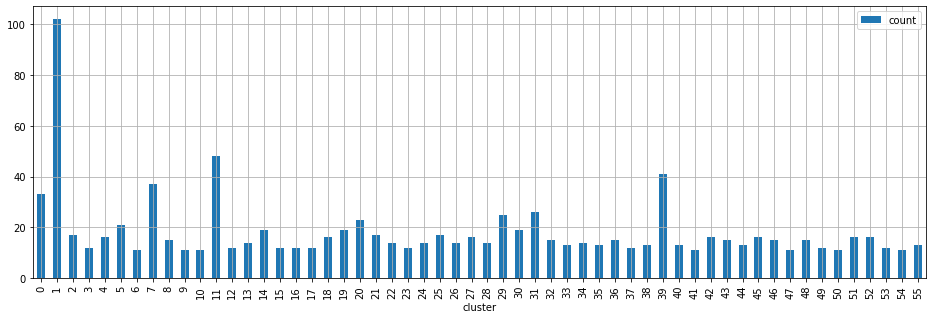

In [105]:
# размеры кластеров
cluster_descr[['cluster','count']]\
    .query('cluster>-1')\
    .set_index('cluster')\
    .plot.bar(grid=True,figsize=(16,5))

In [106]:
def print_cluster_samples(n,ns=5,nt=500):
    count,tags = cluster_descr.query(f'cluster=={n}')[['count','tags']].values[0]#.tolist
    df = data.query(f'cluster=={n}')
    ns_ = min(ns,len(df))
    top = [ t[:nt].replace('\n',' ') for t in df['text'].sample(ns_).values ]
    print('[ КЛАСТЕР %i, элементов: %i, метки: "%s" ]'%(n,count,tags))
    for s in top: print('\n%s ...\n'%(s) )

In [107]:
for n in rng.permutation(cluster_descr['cluster'].max())[:3] :
    print_cluster_samples(n)
    print('\n= = = = = = = = = = = = = = = = = = = = = = = = = =\n')

[ КЛАСТЕР 9, элементов: 11, метки: "politics" ]

Арестованный за взятку экс-губернатор Сахалина Александр Хорошавин обжаловал конфискацию своего имущества в Конституционном суде на 1,1 млрд рублей.  Газета "Коммерсантъ" пишет, что Хорошавины просят Конституционный суд России признать нарушение их конституционных прав законом "О контроле за соответствием расходов лиц, замещающих госдолжности, и иных лиц их доходам" и статьей 235 Гражданского кодекса "Основания прекращения права собственности".  Экс-глава региона, находящийся в СИЗО по делу о кр ...


Бывший губернатор Сахалинской области Александр Хорошавин, его жена Ирина и сын Илья подали в Конституционный суд жалобу, оспаривающую конфискацию имущества до окончания расследования. По данным газеты «Коммерсантъ», жалоба была направлена в суд в ноябре этого года. И в ней Хорошавины оспаривают применение к ним ст. 17 закона «О контроле за соответствием расходов лиц, замещающих госдолжности, и иных лиц их доходам», а также ст. 235 Гражданс